# Experiment: Train DistilBERT Model Experiment

## Confirm Environment

In [1]:
!conda info


     active environment : base
    active env location : /shared/EL9/explorer/anaconda3/2024.06
            shell level : 1
       user config file : /home/neiderer.c/.condarc
 populated config files : 
          conda version : 24.5.0
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=broadwell
                          __conda=24.5.0=0
                          __cuda=12.3=0
                          __glibc=2.34=0
                          __linux=5.14.0=0
                          __unix=0=0
       base environment : /shared/EL9/explorer/anaconda3/2024.06  (read only)
      conda av data dir : /shared/EL9/explorer/anaconda3/2024.06/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64

## Setup and Imports

In [2]:
from emolex.preprocessing import load_mental_health_sentiment_dataset, clean_text, encode_sentiment_labels, split_data, hf_vectorization
from emolex.train import train_hf_model
from emolex.evaluation import plot_training_history, generate_confusion_matrix, generate_classification_report
from emolex.utils import detect_and_set_device

2025-07-02 23:49:48.903142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751514588.923759 4136585 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751514588.930161 4136585 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751514588.946323 4136585 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751514588.946337 4136585 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751514588.946340 4136585 computation_placer.cc:177] computation placer alr

## Device Setup

In [3]:
# Detect and set up GPU or use CPU
device_used = detect_and_set_device()
print(f"TensorFlow is configured to use: {device_used}")

GPU is available. Attempting to use GPU.
Successfully configured GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is configured to use: GPU


## Load Data

In [4]:
df = load_mental_health_sentiment_dataset()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51093 entries, 0 to 51092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    51093 non-null  object
 1   label   51093 non-null  object
dtypes: object(2)
memory usage: 798.5+ KB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


## Clean Data

In [5]:
print(f"\n--- Cleaning Text ---")
df['clean_text'] = df["text"].apply(clean_text)
print("Text cleaning complete. Sample cleaned text:")
print("\n", df[["text", "clean_text"]].sample(5))


--- Cleaning Text ---
Text cleaning complete. Sample cleaned text:

                                                   text  \
32959               no, but i did put on a few pounds.   
31992                    what about the baseball game?   
35958  @joyciebo hi cutie welcome to the twitternation   
5881                  Hareudang- banging-cold..A phase   
2277     Wise people learn from the failures of others   

                                    clean_text  
32959                                put pound  
31992                            baseball game  
35958  joyciebo hi cutie welcome twitternation  
5881              hareudang bangingcolda phase  
2277          wise people learn failure others  


## Encode Labels

In [6]:
print(f"\n--- Encoding Labels ---")
df, encoder = encode_sentiment_labels(df)
print("Label encoding complete. Sample encoded labels:")
print("\n", df[['label', 'label_encoded']].sample(5))


--- Encoding Labels ---
Label Encoding Map: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Label encoding complete. Sample encoded labels:

          label  label_encoded
532    Anxiety              0
41947   Normal              3
1953    Normal              3
36978   Normal              3
35260  Anxiety              0


## Train-Test Split

In [7]:
print("\n--- Perform Train-Test Split ---")
X_train_raw, X_test_raw, y_train, y_test = split_data(df) 
print(f"Train set size: {len(X_train_raw)} samples")
print(f"Test set size: {len(X_test_raw)} samples")


--- Perform Train-Test Split ---
Train set size: 40874 samples
Test set size: 10219 samples


## Vectorization

In [8]:
print("\n--- Performing Text Vectoriation ---")
X_train_tokenized, X_test_tokenized = hf_vectorization("distilbert", X_train_raw, X_test_raw, y_train, y_test)


--- Performing Text Vectoriation ---
Creating Hugging Face Datasets from input data...
Loading DistilBERT tokenizer...
Tokenizing datasets...


/home/neiderer.c/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/40874 [00:00<?, ? examples/s]

Map:   0%|          | 0/10219 [00:00<?, ? examples/s]

Map:   0%|          | 0/40874 [00:00<?, ? examples/s]

Map:   0%|          | 0/10219 [00:00<?, ? examples/s]

## Train Model

In [9]:
trainer, results = train_hf_model("distilbert", X_train_tokenized, X_test_tokenized, num_classes=len(encoder.classes_), num_train_epochs=1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading pre-trained DistilBERT model...
Defining training arguments...
Loading evaluation metrics...
Setting up Hugging Face Trainer...
Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.539200,0.522089,0.791565,0.759828,0.726491,0.741237


Checkpoint destination directory ./bert_output/checkpoint-2555 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Model training complete.
Evaluating model...


Model evaluation results: {'eval_loss': 0.5220887064933777, 'eval_accuracy': 0.7915647323612878, 'eval_macro_precision': 0.7598281488868557, 'eval_macro_recall': 0.7264908863383271, 'eval_macro_f1': 0.741236820161466, 'eval_runtime': 19.4908, 'eval_samples_per_second': 524.297, 'eval_steps_per_second': 32.785, 'epoch': 1.0}


## Evaluate Model

In [14]:
import pandas as pd
history = pd.DataFrame(trainer.state.log_history)#.drop_duplicates(subset=["epoch"])
history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_macro_precision,eval_macro_recall,eval_macro_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9002,4.976642,0.000040,0.20,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.6915,5.808718,0.000030,0.39,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.5870,6.657062,0.000021,0.59,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.5627,8.902431,0.000011,0.78,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.5392,2.871088,0.000001,0.98,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.00,2555,0.522089,0.791565,0.759828,0.726491,0.741237,19.5427,522.907,32.698,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,1.00,2555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.534,156.286,9.769,1.057608e+15,0.654054
7,NaN,NaN,NaN,1.00,2555,0.522089,0.791565,0.759828,0.726491,0.741237,19.4908,524.297,32.785,NaN,NaN,NaN,NaN,NaN


In [16]:
print("\n--- Predict Test Classes ---")
import numpy as np
y_pred = trainer.predict(X_test_tokenized).predictions
y_pred_classes = np.argmax(y_pred, axis=1)


--- Predict Test Classes ---



--- Generate Confusion Matrix ---


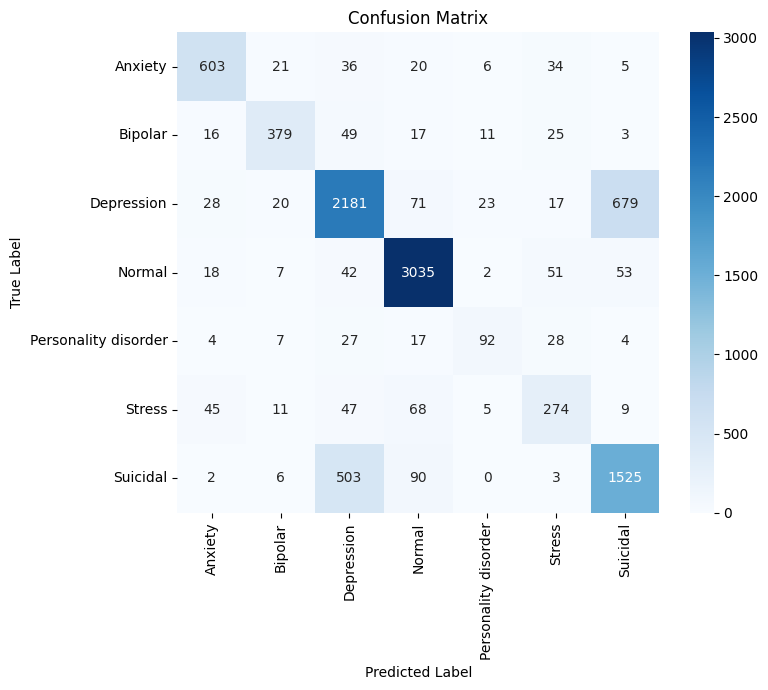

In [18]:
print("\n--- Generate Confusion Matrix ---")
fig, ax = generate_confusion_matrix(y_test, y_pred_classes, class_labels=encoder.classes_)

In [19]:
print("\n--- Generate Classification Report ---")
generate_classification_report(y_test, y_pred_classes, class_labels=encoder.classes_)


--- Generate Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.84      0.83      0.84       725
             Bipolar       0.84      0.76      0.80       500
          Depression       0.76      0.72      0.74      3019
              Normal       0.91      0.95      0.93      3208
Personality disorder       0.66      0.51      0.58       179
              Stress       0.63      0.60      0.62       459
            Suicidal       0.67      0.72      0.69      2129

            accuracy                           0.79     10219
           macro avg       0.76      0.73      0.74     10219
        weighted avg       0.79      0.79      0.79     10219

